In [1]:
import intake
import xarray as xr
import numpy as np
# only for plotting
import pymistral
import matplotlib.pyplot as plt

In [2]:
zarr = '/work/mh0727/m300524/miklip_post/DPLE.zarr'
zarr5 = zarr.replace('.zarr','_5x5.zarr')
zarr5_ym = zarr5.replace('.zarr','_ym.zarr')
zarr_hist = '/work/mh0727/m300524/miklip_post/CESM_LE.zarr'
zarr_hist5 = zarr_hist.replace('.zarr','_5x5.zarr')
zarr_hist5_ym = zarr_hist5.replace('.zarr','_ym.zarr')

In [3]:
import xesmf as xe

def regrid(ds, deg=5):
    ds_out = xe.util.grid_global(deg,deg)
    regridder = xe.Regridder(ds, ds_out, 'bilinear')
    ds_out = regridder(ds)
    return ds_out

# preprocess
- you only need to do this once! Takes ~10min to aggregate to `zarr`. Then start from `1.3 obs`
- `intake-esm` catalog built from `/home/mpim/m300524/intake-esm-datastore/builders/mistral-miklip_catalog_builder_chris.ipynb`

In [4]:
col_url = "/home/mpim/m300524/intake-esm-datastore/catalogs/mistral-DPLE.json"
col = intake.open_esm_datastore(col_url)
col

In [173]:
#col.df.iloc[0].path

In [69]:
from tqdm.auto import tqdm
import os
from climpred.preprocessing.shared import rename_to_climpred_dims, set_integer_time_axis

## hindcast

In [88]:
inits = sorted(col.df.experiment.unique())

In [ ]:
for init in tqdm(inits):
    cat = col.search(experiment=init)
    dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': -1}},
                                    preprocess=set_integer_time_axis)

    _, ds = dset_dict.popitem()
    ds = rename_to_climpred_dims(ds)
    ds=ds['tas'].to_dataset(name='tas').expand_dims('init')
    ds['init']=[int(init.strip('decadal'))]
    if not os.path.exists(zarr):
        ds.to_zarr(zarr, consolidated=True, mode='w')
    else:
        ds.to_zarr(zarr, consolidated=True, mode="a", append_dim="init")

### regrid

In [90]:
dsz = xr.open_zarr(zarr)

In [93]:
dszr = regrid(dsz)

Create weight file: bilinear_192x288_36x72.nc
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.


In [98]:
dszr.chunk({'init':-1}).to_zarr(zarr5, consolidated=True)

### ym

In [233]:
dsz = xr.open_zarr(zarr5)

In [234]:
dsz=dsz.isel(lead=slice(2,None))

In [235]:
dsz['lead']=xr.cftime_range(start='2000',freq='MS',periods=dsz.lead.size)

In [236]:
dsz=dsz.groupby('lead.year').mean().rename({'year':'lead'})
dsz['lead']=np.arange(1,1+dsz.lead.size)

In [238]:
dsz.chunk({'member':-1}).to_zarr(zarr5_ym)

## hist

In [129]:
dset_dict = col.search(experiment='historicalext',model='CCSM4').to_dataset_dict(cdf_kwargs={'chunks': {'time': -1}})
_, ds = dset_dict.popitem()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'institute.model.experiment.mip_table'


In [130]:
del ds['height']
ds = ds.rename({'ensemble_member':'member'})['tas'].to_dataset(name='tas').sel(time=slice('1950',None))

In [134]:
ds.to_zarr(zarr_hist, consolidated=True)

### regrid

In [136]:
dsz = xr.open_zarr(zarr_hist)

In [138]:
dszr = regrid(dsz)
dszr.chunk('auto').to_zarr(zarr_hist5, consolidated=True)

Overwrite existing file: bilinear_192x288_36x72.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.


### ym

In [155]:
dsz = xr.open_zarr(zarr_hist5)

In [159]:
dsz=dsz.groupby('time.year').mean().rename({'year':'time'}).chunk(-1)

In [162]:
dsz.to_zarr(zarr_hist5_ym)

## obs 

In [5]:
#cat = intake.open_catalog('/home/mpim/m300524/remote_climate_data/master.yaml')

In [6]:
obs = xr.open_dataset('/home/mpim/m300524/remote_climate_data/HadCRUT4/HadCRUT.4.6.0.0.median.nc')
obs = obs.rename({'temperature_anomaly':'tas','longitude':'lon','latitude':'lat'})

In [7]:
obs = obs.sel(time=slice('1950','2019'))['tas']

### regrid

In [8]:
obs = regrid(obs)

Overwrite existing file: bilinear_36x72_36x72.nc 
 You can set reuse_weights=True to save computing time.


### ym

In [9]:
obs = obs.groupby('time.year').mean().rename({'year':'time'}).compute()

# verification

In [10]:
use_distributed=False
if use_distributed:
    from dask.distributed import Client
    import multiprocessing
    ncpu = multiprocessing.cpu_count()
    threads = 6
    nworker = ncpu//threads
    print(f'Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}')

    client = Client(processes=True, threads_per_worker=threads, n_workers=nworker, memory_limit='256GB')
    client

In [11]:
from climpred import HindcastEnsemble

In [12]:
hind = xr.open_zarr(zarr5_ym)
hist = xr.open_zarr(zarr_hist5_ym)

In [13]:
he = HindcastEnsemble(hind).add_uninitialized(hist).add_observations(obs.sel(time=slice(None,2018)), 'HadCRUT4')

## ACC

In [14]:
murcss_cb = {'vmin':-1, 'vmax':1, 'levels': 21, 'cmap':'RdBu_r'}

In [15]:
metric='acc'
comparison='e2o'
alignment='same_verifs'

In [16]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [17]:
skill = he.verify(metric=metric, comparison=comparison, alignment=alignment)
logger.setLevel(logging.ERROR)

INFO:root:lead: 01 | inits: 1963-01-01 00:00:00-2015-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:lead: 02 | inits: 1962-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:lead: 03 | inits: 1961-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:lead: 04 | inits: 1960-01-01 00:00:00-2012-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:lead: 05 | inits: 1959-01-01 00:00:00-2011-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:lead: 06 | inits: 1958-01-01 00:00:00-2010-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:lead: 07 | inits: 1957-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:lead: 08 | inits: 1956-01-01 00:00:00-2008-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:lead: 09 | inits: 1955-01-01 00:00:00-2007-01-

In [16]:
%time skill = skill.compute()

CPU times: user 785 ms, sys: 1.5 s, total: 2.29 s
Wall time: 443 ms


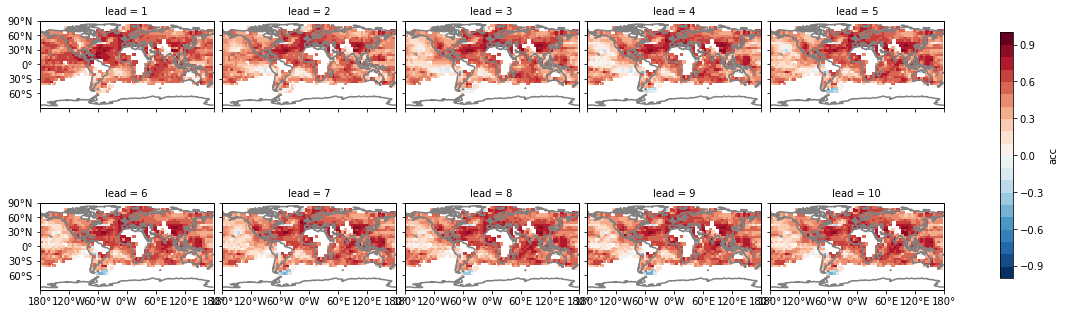

In [17]:
skill.tas.rename(metric).plot_map(col='lead',col_wrap=5, **murcss_cb)

## bias

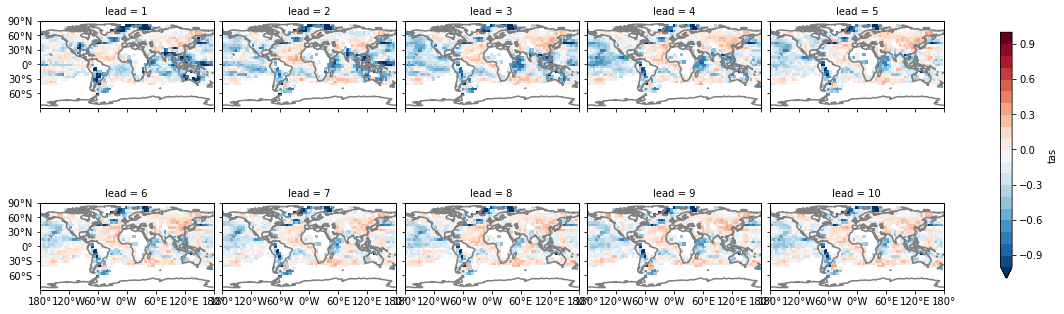

In [53]:
he.verify(metric='conditional_bias', comparison=comparison, alignment=alignment).tas.plot_map(col='lead',col_wrap=5, **murcss_cb)

## bias removal

In [19]:
he_bias_reduced = he.reduce_bias(alignment=alignment).persist()

## CRPSS_ES

CPU times: user 30.8 s, sys: 14.6 s, total: 45.4 s
Wall time: 12.4 s


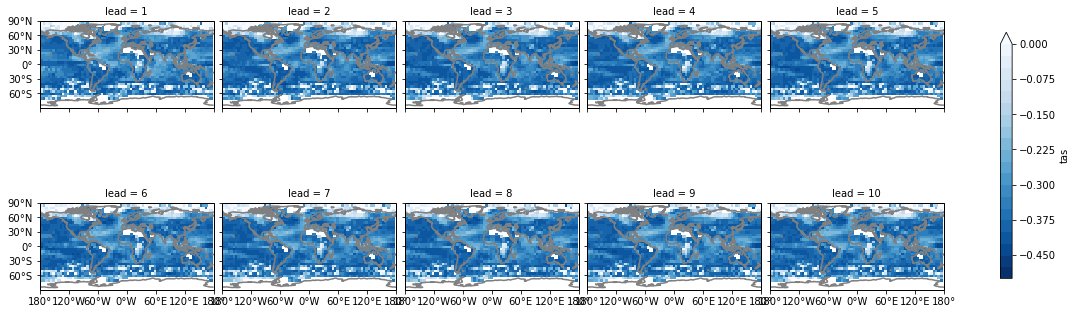

In [61]:
%time he_bias_reduced.verify(metric='crpss_es', comparison='m2o', alignment=alignment).mean('time').tas.plot_map(col='lead',col_wrap=5, cmap='Blues_r',
                                                                                                                 levels=21, vmin=-.5, vmax=0)

## bootstrapping

In [23]:
def plot_bootstrapped(bs,**kwargs):
    sig_mask = bs.sel(results='p',kind='uninit')
    fg = bs.sel(results='skill',kind='init').plot_map(**murcss_cb,**kwargs)

    def f(ds, **kwargs):
        l=ds.lead
        kwargs['levels'] = [0.,.05,1.]
        kwargs['cmap'] = None
        to_sel = {d:ds[d] for d in ['alignment','lead'] if d in ds.coords}
        ds_plot = sig_mask.sel(to_sel).where(~ds.isnull())
        ds_plot['lon']=sig_mask.lon
        cs = ds_plot.plot.contourf(hatches=['...',''], colors='none',**kwargs)
        kwargs['ax'].set_global()
        return cs

    return fg.map_dataarray(f, x='lon', y='lat', add_colorbar=False)

In [19]:
%time bs = he.sel(lead=[1]).bootstrap(metric='acc', comparison='e2o', alignment='same_inits',iterations=1000)

choose resample_func _resample_iterations
CPU times: user 18.6 s, sys: 7.31 s, total: 25.9 s
Wall time: 26.2 s


In [20]:
%time bs = bs.compute()

CPU times: user 2min 20s, sys: 11min 8s, total: 13min 28s
Wall time: 28.5 s


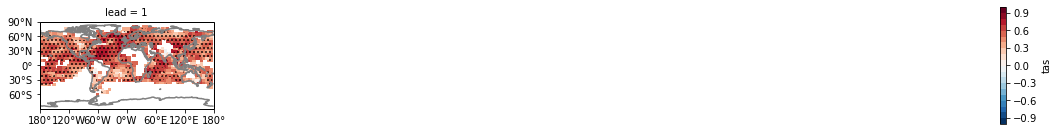

In [24]:
plot_bootstrapped(bs.tas, col='lead',col_wrap=5)

In [ ]:
# compute skill for more than one lead for 1000 iterations: jupyter kernel silently restarts
#%time bs = he.bootstrap(metric='acc', comparison='e2o', alignment='same_inits',iterations=1000)

In [19]:
# compute skill on eager data ==> memory error
#%time bs = he.compute().bootstrap(metric='acc', comparison='e2o', alignment='same_inits',iterations=500)

# reproducing MurCSS
https://www-miklip.dkrz.de/history/150581/results/

In [56]:
metric='acc'
comparison='e2o'
iterations=1000

In [57]:
he_reproduce = HindcastEnsemble(hind).add_uninitialized(hist).add_observations(obs.sel(time=slice(None,2019)), 'HadCRUT4')

Having issues with dying jupyter kernel:
- calculate each `lead` in a separate `.compute()` call

In [58]:
%%time
alignment='same_verif'
logger.setLevel(logging.INFO)
skill_same_verifs = xr.concat([
    he_reproduce.sel(lead=[1]).isel(init=slice(5,None)).bootstrap(metric=metric, alignment=alignment,iterations=iterations).compute(),
    he_reproduce.chunk({'lead':-1}).isel(init=slice(4,None)).smooth({'lead':4}).sel(lead=[2]).bootstrap(iterations=iterations,metric=metric,alignment=alignment).compute(),
    he_reproduce.chunk({'lead':-1}).smooth({'lead':4}).sel(lead=[6]).bootstrap(iterations=iterations,metric=metric,alignment=alignment).compute()
                    ],'lead')
logger.setLevel(logging.ERROR)

choose resample_func _resample_iterations


INFO:root:`compute_hindcast` for metric "pearson_r", comparison "m2o", dim "time", and alignment "same_verif" at 2020-08-28 16:00:20.245324
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 01 | inits: 1959-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "same_verif" at 2020-08-28 16:00:34.901462
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 01 | inits: 1959-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "same_verif" at 2020-08-28 16:00:37.089570
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 01 | inits: 1959-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00


choose resample_func _resample_iterations


INFO:root:`compute_hindcast` for metric "pearson_r", comparison "m2o", dim "time", and alignment "same_verif" at 2020-08-28 16:01:11.774472
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 02 | inits: 1958-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "same_verif" at 2020-08-28 16:01:26.499946
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 02 | inits: 1958-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "same_verif" at 2020-08-28 16:01:28.684497
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 02 | inits: 1958-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00


choose resample_func _resample_iterations


INFO:root:`compute_hindcast` for metric "pearson_r", comparison "m2o", dim "time", and alignment "same_verif" at 2020-08-28 16:02:07.097619
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 06 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "same_verif" at 2020-08-28 16:02:21.862563
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 06 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "same_verif" at 2020-08-28 16:02:24.068918
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 06 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00


CPU times: user 7min 37s, sys: 26min 57s, total: 34min 35s
Wall time: 2min 43s


In [59]:
%%time
alignment='same_inits'
logger.setLevel(logging.INFO)
skill_same_inits = xr.concat([
    he_reproduce.sel(lead=[1]).isel(init=slice(None,-5)).bootstrap(metric=metric, alignment=alignment,iterations=iterations).compute(),
    he_reproduce.chunk({'lead':-1}).isel(init=slice(None,-4)).smooth({'lead':4}).sel(lead=[2]).bootstrap(iterations=iterations,metric=metric,alignment=alignment).compute(),
    he_reproduce.chunk({'lead':-1}).isel(init=slice(None,None)).smooth({'lead':4}).sel(lead=[6]).bootstrap(iterations=iterations,metric=metric,alignment=alignment).compute()
                    ],'lead')
logger.setLevel(logging.ERROR)

choose resample_func _resample_iterations


INFO:root:`compute_hindcast` for metric "pearson_r", comparison "m2o", dim "time", and alignment "same_inits" at 2020-08-28 16:03:02.922549
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 01 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1955-01-01 00:00:00-2010-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "same_inits" at 2020-08-28 16:03:17.552921
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 01 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1955-01-01 00:00:00-2010-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "same_inits" at 2020-08-28 16:03:19.534826
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 01 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1955-01-01 00:00:00-2010-01-01 00:00:00


choose resample_func _resample_iterations


INFO:root:`compute_hindcast` for metric "pearson_r", comparison "m2o", dim "time", and alignment "same_inits" at 2020-08-28 16:03:53.631304
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 02 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1956-01-01 00:00:00-2011-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "same_inits" at 2020-08-28 16:04:08.082858
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 02 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1956-01-01 00:00:00-2011-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "same_inits" at 2020-08-28 16:04:10.058158
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 02 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1956-01-01 00:00:00-2011-01-01 00:00:00


choose resample_func _resample_iterations


INFO:root:`compute_hindcast` for metric "pearson_r", comparison "m2o", dim "time", and alignment "same_inits" at 2020-08-28 16:04:48.928225
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 06 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "same_inits" at 2020-08-28 16:05:03.658292
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 06 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "same_inits" at 2020-08-28 16:05:05.646117
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 06 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00


CPU times: user 7min 38s, sys: 27min 12s, total: 34min 51s
Wall time: 2min 41s


In [60]:
%%time
alignment='maximize'
logger.setLevel(logging.INFO)
skill_maximize = xr.concat([
    he_reproduce.sel(lead=[1]).bootstrap(metric=metric, alignment=alignment,iterations=iterations).compute(),
    he_reproduce.chunk({'lead':-1}).smooth({'lead':4}).sel(lead=[2]).bootstrap(iterations=iterations,metric=metric,alignment=alignment).compute(),
    he_reproduce.chunk({'lead':-1}).smooth({'lead':4}).sel(lead=[6]).bootstrap(iterations=iterations,metric=metric,alignment=alignment).compute()
                    ],'lead')
logger.setLevel(logging.ERROR)

choose resample_func _resample_iterations


INFO:root:`compute_hindcast` for metric "pearson_r", comparison "m2o", dim "time", and alignment "maximize" at 2020-08-28 16:05:44.427215
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 01 | inits: 1954-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1955-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "maximize" at 2020-08-28 16:05:59.906252
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 01 | inits: 1954-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1955-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "maximize" at 2020-08-28 16:06:02.046010
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 01 | inits: 1954-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1955-01-01 00:00:00-2015-01-01 00:00:00


choose resample_func _resample_iterations


INFO:root:`compute_hindcast` for metric "pearson_r", comparison "m2o", dim "time", and alignment "maximize" at 2020-08-28 16:06:38.418108
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 02 | inits: 1954-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1956-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "maximize" at 2020-08-28 16:06:53.965220
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 02 | inits: 1954-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1956-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "maximize" at 2020-08-28 16:06:56.305138
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 02 | inits: 1954-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1956-01-01 00:00:00-2015-01-01 00:00:00


choose resample_func _resample_iterations


INFO:root:`compute_hindcast` for metric "pearson_r", comparison "m2o", dim "time", and alignment "maximize" at 2020-08-28 16:07:36.826025
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 06 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "maximize" at 2020-08-28 16:07:51.276517
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 06 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:`compute_hindcast` for metric "pearson_r", comparison "e2o", dim "time", and alignment "maximize" at 2020-08-28 16:07:53.522764
++++++++++++++++++++++++++++++++++++++++++++++++
INFO:root:lead: 06 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00


CPU times: user 7min 59s, sys: 29min 21s, total: 37min 20s
Wall time: 2min 48s


In [61]:
skill = xr.concat([skill_same_verifs,skill_same_inits,skill_maximize],'alignment')
skill['alignment'] = ['same_verifs','same_inits','maximize']

In [62]:
skill['lead'] = [1,'2-5','6-9']
skill = skill.tas.rename(metric)

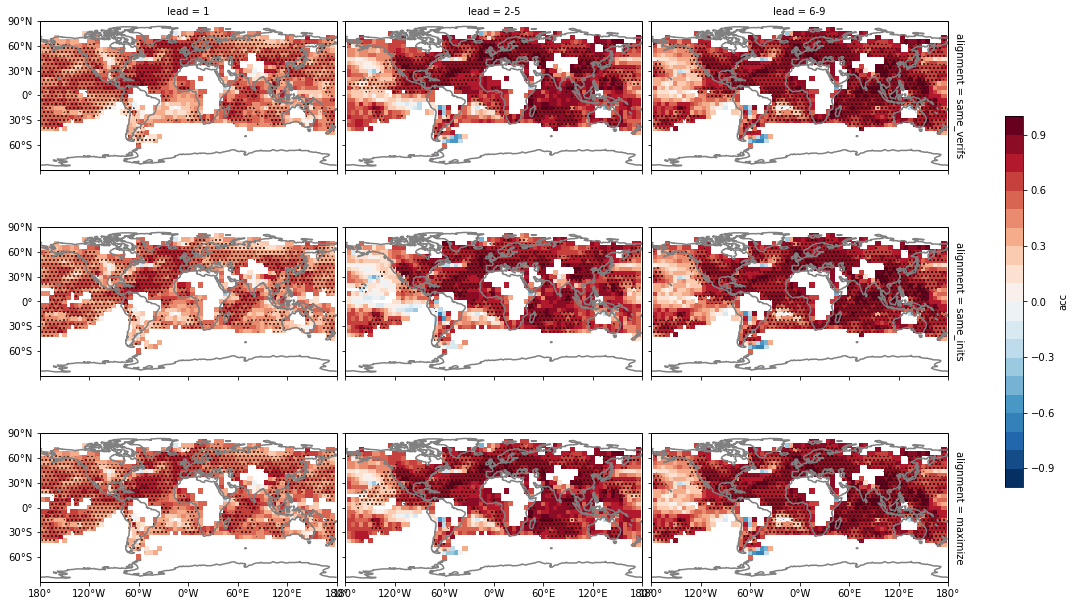

In [64]:
plot_bootstrapped(skill,col='lead',row='alignment', aspect=1.7)

#### getting MurCSS nc results

In [36]:
# read file
lead='*'#'1-1'
input_no = 1
res_domain='accuracy'
filename='correlation'
murcss_output_path=f'/work/bmx825/miklip-work/b324031/evaluation_system/output/murcss/150581/20181123-092729_tas_user-b324031_le_ncar_cesm_decadal_user-b324031_historicalext_ncar_ccsm4_historicalext_hadcrut4-median_-250:110:-90:90_1954-2008/{lead}/user-b324031_le_cesm_decadal_input{input_no}/{res_domain}'
f=f'{murcss_output_path}/{lead.replace("-","_") if "-" in lead else lead}_tas_user-b324031_le_cesm_decadal_1954-2008_input{input_no}_{filename}.nc'

ds_murcss = xr.open_mfdataset(f).rename({'time':'lead'})['tas']

In [37]:
ds_murcss['lead']=skill.lead.values
# align lon, lat
ds_murcss = regrid(ds_murcss)

Overwrite existing file: bilinear_36x72_36x72.nc 
 You can set reuse_weights=True to save computing time.


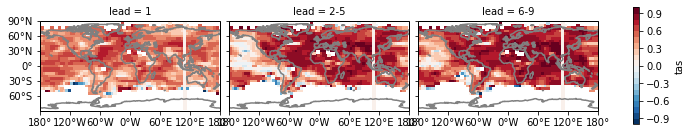

In [38]:
ds_murcss.plot_map(col='lead',**murcss_cb)

Text(0.5, 0.98, 'climpred - MurCSS')

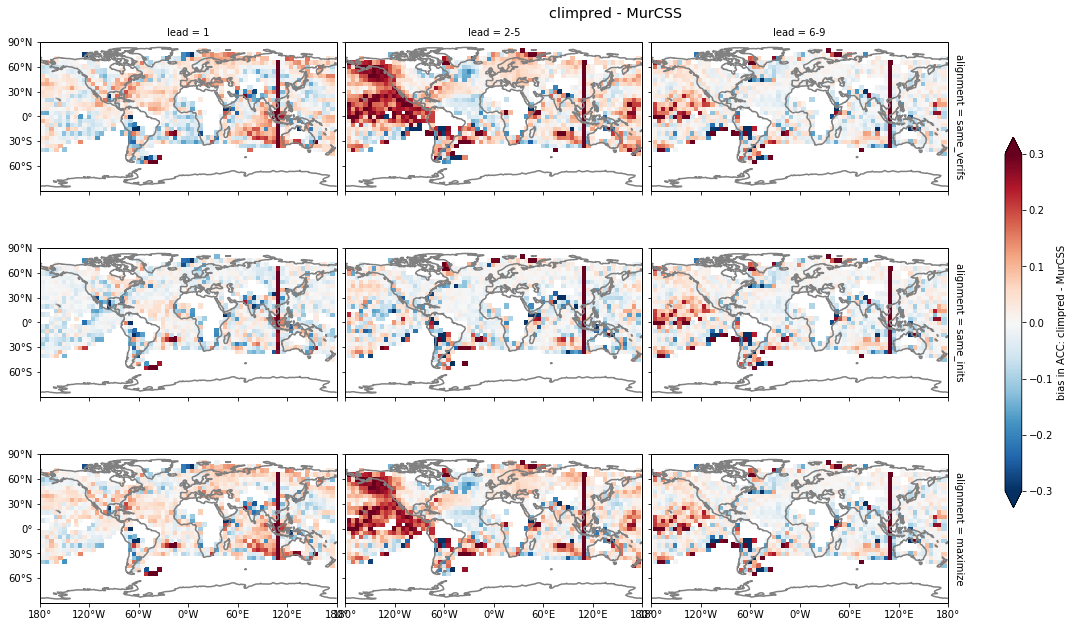

In [67]:
vl=.3
(skill.sel(kind='init',results='skill')-ds_murcss).rename('bias in ACC: climpred - MurCSS').plot_map(col='lead',row='alignment',vmin=-vl,vmax=vl,cmap='RdBu_r',aspect=1.7)
plt.suptitle('climpred - MurCSS',fontsize='x-large')

- similar results for `same_inits`, which is what `MurCSS` uses

# reproducing Yeager et al. 2018 
## Fig.4abc MSSS SAT against CRU-TSv4.00

- prior drift-adjustment: guessing linear detrend and lead-time dependent bias removal

In [256]:
# todo: get other dataset: isnt CRU-TS close to HadCRUT?

In [247]:
metric='msss'
comparison='e2o'
alignment='maximize'

In [248]:
from esmtools.stats import rm_poly
o=1

In [249]:
# rm constant bias
he._datasets['initialized'] = he.get_initialized() - he.get_initialized().mean(['init','lead'])
he._datasets['uninitialized'] = he.get_uninitialized() - he.get_uninitialized().mean(['time'])

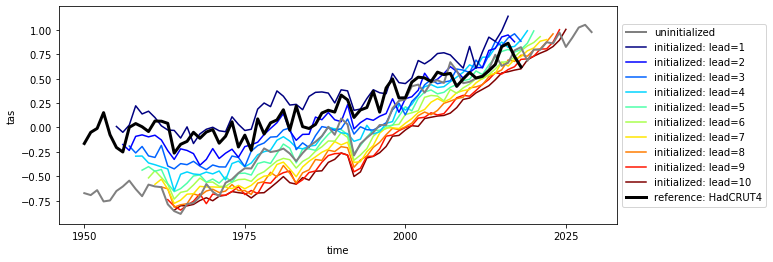

In [250]:
hes = (he).mean(['x','y']).compute()
hes.plot()

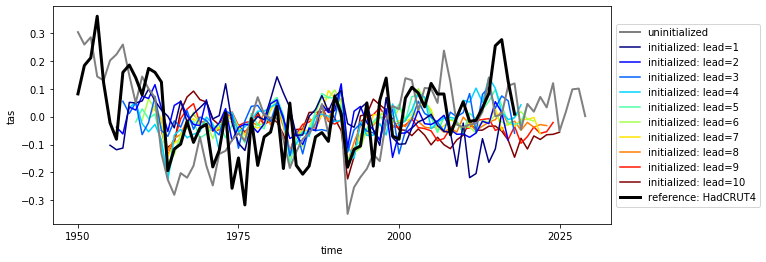

In [254]:
hes.map(rm_poly, dim='time',order=o).map(rm_poly, dim='lead',order=o).reduce_bias(alignment='maximize').plot()

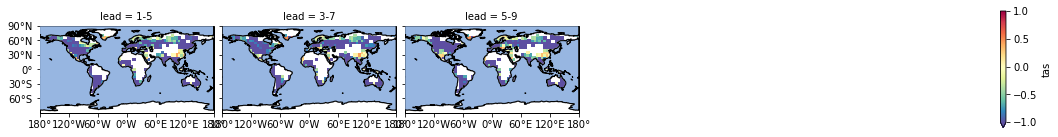

In [255]:
he.map(rm_poly, dim='time',order=o).map(rm_poly, dim='lead',order=o).chunk({'lead':-1}).reduce_bias(alignment=alignment).smooth({'lead':5}).verify(metric=metric, comparison=comparison, alginment=alignment).sel(lead=['1-5','3-7','5-9']).tas.plot_map(col='lead',col_wrap=5, vmin=-1, vmax=1, cmap='Spectral_r', feature='ocean')